First, Compile a list of all chandra sources that could possibly be in PASSAGE (within 3 arcmin of the center)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.coordinates as coord
from astroquery.heasarc import Heasarc
from astropy.utils.data import download_file
import astropy.units as u
import pandas as pd
from astroquery.vizier import Vizier
import astropy.table as tab
from matplotlib.patches import Circle
from ipywidgets import interact
import os


In [6]:
check_radius=0.05*u.deg #=3 arcmin
catalog_names = {'chandra':'csc',
                 'xmm':'xmmstack',
                 'milliquas':'milliquas'}
                 
par_coords_import=np.loadtxt('./par_coords.csv',dtype='str',delimiter=',')
par_coords_list=coord.SkyCoord(ra=par_coords_import[:,1],dec=par_coords_import[:,2],unit=(u.deg, u.deg))
par_names=par_coords_import[:,0]

In [35]:
temp=pd.read_csv('./csc_table.csv', delimiter=',')
print(temp)
temp = temp.drop_duplicates(subset=['name'])
print(len(temp))
temp.to_csv('./csc_table_nodup.tsv', index=False, sep='\t')




                      name          ra        dec  significance  \
0    2CXO J111959.4+063641  169.997826   6.611406      4.722222   
1    2CXO J112001.2+063610  170.005175   6.602871      2.555556   
2    2CXO J112008.8+063438  170.036895   6.577439      2.205128   
3    2CXO J112009.1+063814  170.038094   6.637490      4.315789   
4    2CXO J114824.6+524847  177.102851  52.813074      2.702703   
..                     ...         ...        ...           ...   
401  2CXO J103027.1+052917  157.613073   5.488196      4.045455   
402  2CXO J103028.4+053114  157.618569   5.520807     11.491644   
403  2CXO J095946.7-224853  149.944730 -22.814813      4.833333   
404  2CXO J095951.8-224728  149.965982 -22.791243      6.024397   
405  2CXO J100001.0-224713  150.004490 -22.787133      3.294118   

     error_ellipse_r0  error_ellipse_r1  error_ellipse_angle par_name  
0            1.159674          0.635005           136.167155   Par001  
1            2.950725          1.257915           1

In [3]:
#Stacked Observation Detections Table Chandra

stack_obs = pd.read_csv('./cscresults_nodup.tsv', sep='\t', comment='#')

#print(stack_obs.columns)


#choose the best stack image for each object based on likelihood in broadband
unique_obj = stack_obs['master_source.name'].unique()

chosen_stacks = pd.DataFrame(columns=stack_obs.columns)

for obj in unique_obj:
    #print('Processing object:', obj)
    
    obj_stacks= stack_obs[stack_obs['master_source.name'] == obj]

    max_row = obj_stacks[obj_stacks['stack_source.likelihood_b'] == obj_stacks['stack_source.likelihood_b'].max()]

    chosen_stacks = pd.concat([chosen_stacks, max_row], ignore_index=True)

#check for multiple sources in the same stack region image
chosen_stacks_dup=chosen_stacks[chosen_stacks.duplicated(subset=['stack_source.detect_stack_id','stack_source.region_id'], 
                                       keep=False)]

print(f"The number of best stack images is {len(chosen_stacks)} - should match the number of unique objects {len(unique_obj)}")
print(f"The number of total stack images was {len(stack_obs)}")
print(f"The number of sources which share a 'best stack image' with another source is {len(chosen_stacks_dup)}")

#folder with the downloaded chandra stack region images
filepath='/home/jacoblevine7/AGN_proj/agn_storage/chan_pix/cdapackage.6.20250707.175119.001'
filenames= os.listdir(filepath)
print(filenames)

#Stripping the .gz extension and decompressing the files
for file in os.listdir(filepath):
    if file.endswith('.fits.gz'):
        print(file)
        os.system(f'gzip -d {os.path.join(filepath,file)}')  # Decompress the file

good_filenames = np.empty(dtype=str, shape=0)
#read in csc table first, then everything needs to be done in the same order as the csc_table.csv
csc_table = pd.read_csv('./csc_table.csv', sep=',')



#choose which files to put into the chan_pix_good folder - id matching the stack source image 


#this section is bad, need to make more efficient
#it loops through the chosen_stacks and then through all the filenames, which is not efficient
#it should loop through the filenames and then check if the filename matches the chosen_stacks

for i in range(len(chosen_stacks)):
    
    row = csc_table.iloc[i]
    object_name = row['name']
    temp_chosen_row = chosen_stacks[chosen_stacks['master_source.name'] == object_name]

    for filename in filenames:
        if filename.endswith('.fits'):
        

            if temp_chosen_row['stack_source.detect_stack_id'].item() in filename:
                if str(temp_chosen_row['stack_source.region_id'].item()).zfill(4)+'b' in filename:
                    
                    good_filenames = np.append(good_filenames, filename)

# make a new pandas series with the good filenames
good_filenames = pd.Series(good_filenames, name='chan_filename')




csc_table['chan_filename'] = good_filenames
csc_table.to_csv('./csc_table.csv', index=False, sep=',')

destination_folder = '/home/jacoblevine7/AGN_proj/agn_storage/chan_pix/chan_pix_good'
"""
for i in range(len(good_filenames)):
    source_path = os.path.join(filepath, good_filenames[i])
    destination_path = os.path.join(destination_folder, good_filenames[i])

    os.system(f'cp {source_path} {destination_path}')  # Use cp command to copy files
"""


/tmp/ipykernel_8478/1540790532.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chosen_stacks = pd.concat([chosen_stacks, max_row], ignore_index=True)


The number of best stack images is 387 - should match the number of unique objects 387
The number of total stack images was 1437
The number of sources which share a 'best stack image' with another source is 4


FileNotFoundError: [Errno 2] No such file or directory: '/home/jacoblevine7/AGN_proj/agn_storage/chan_pix/cdapackage.6.20250707.175119.001'

In [7]:
df_counts=pd.DataFrame(columns=catalog_names.keys(),index=par_names)

#identifying number of objects in each field for chandra and xmm

for j in range(len((catalog_names.values()))):
    print(list(catalog_names.values())[j]+'\n')

    column_counts=np.zeros(len(par_coords_list))

    for i in range(len(par_coords_list)):

            current_par=par_names[i]

            print(current_par+'\n')

            #query chandra
            result = Heasarc.query_region(par_coords_list[i],catalog=list(catalog_names.values())[j],radius=check_radius)

            if len(result) > 0:
                column_counts[i]=len(result)
            else:
                print("Nothing found for "+ current_par)
                continue

    df_counts[list(catalog_names.keys())[j]]=column_counts

csc

Par001

Par002

Par003

Par004

Par005

Par006

Par007



Nothing found for Par007
Par008

Par009

Par010



Nothing found for Par010
Par011

Par012



Nothing found for Par012
Par013



Nothing found for Par013
Par014

Par015



Nothing found for Par015
Par016



Nothing found for Par016
Par017

Par018



Nothing found for Par018
Par019



Nothing found for Par019
Par020

Par021



Nothing found for Par021
Par022

Par023

Par024

Par025

Par026

Par027

Par028

Par029

Par030



Nothing found for Par030
Par031

Par032

Par033

Par034



Nothing found for Par034
Par035

Par036



Nothing found for Par036
Par037



Nothing found for Par037
Par038

Par039



Nothing found for Par039
Par040

Par041

Par042



Nothing found for Par042
Par043

Par044



Nothing found for Par044
Par045



Nothing found for Par045
Par046

Par047

Par048

Par049

Par050

Par051

Par052

Par053

Par054



Nothing found for Par054
Par055



Nothing found for Par055
Par056

Par057

Par058



Nothing found for Par058
Par059

Par060

Par061



Nothing found for Par061
Par062



Nothing found for Par062
Par063

xmmstack

Par001

Par002

Par003

Par004



Nothing found for Par004
Par005

Par006

Par007

Par008

Par009



Nothing found for Par009
Par010

Par011



Nothing found for Par011
Par012



Nothing found for Par012
Par013



Nothing found for Par013
Par014



Nothing found for Par014
Par015



Nothing found for Par015
Par016



Nothing found for Par016
Par017

Par018



Nothing found for Par018
Par019



Nothing found for Par019
Par020

Par021



Nothing found for Par021
Par022

Par023

Par024

Par025

Par026

Par027

Par028

Par029

Par030

Par031

Par032

Par033



Nothing found for Par033
Par034



Nothing found for Par034
Par035

Par036

Par037

Par038



Nothing found for Par038
Par039



Nothing found for Par039
Par040

Par041



Nothing found for Par041
Par042



Nothing found for Par042
Par043

Par044



Nothing found for Par044
Par045



Nothing found for Par045
Par046

Par047

Par048

Par049

Par050

Par051

Par052

Par053

Par054

Par055

Par056

Par057

Par058



Nothing found for Par058
Par059

Par060



Nothing found for Par060
Par061



Nothing found for Par061
Par062



Nothing found for Par062
Par063



Nothing found for Par063
milliquas

Par001

Par002

Par003

Par004



Nothing found for Par004
Par005

Par006

Par007



Nothing found for Par007
Par008

Par009

Par010



Nothing found for Par010
Par011



Nothing found for Par011
Par012



Nothing found for Par012
Par013

Par014



Nothing found for Par014
Par015



Nothing found for Par015
Par016



Nothing found for Par016
Par017

Par018



Nothing found for Par018
Par019

Par020

Par021



Nothing found for Par021
Par022

Par023

Par024

Par025

Par026

Par027



Nothing found for Par027
Par028

Par029

Par030

Par031



Nothing found for Par031
Par032



Nothing found for Par032
Par033

Par034

Par035



Nothing found for Par035
Par036



Nothing found for Par036
Par037

Par038

Par039

Par040



Nothing found for Par040
Par041

Par042



Nothing found for Par042
Par043

Par044



Nothing found for Par044
Par045



Nothing found for Par045
Par046

Par047

Par048

Par049

Par050

Par051

Par052

Par053

Par054

Par055

Par056

Par057



Nothing found for Par057
Par058



Nothing found for Par058
Par059

Par060

Par061

Par062

Par063

Nothing found for Par063


In [8]:
print(df_counts)

print(sum(df_counts['chandra']),sum(df_counts['xmm']),sum(df_counts['milliquas']))

        chandra   xmm  milliquas
Par001      4.0  14.0        2.0
Par002     13.0  16.0        1.0
Par003     19.0  11.0        8.0
Par004      2.0   0.0        0.0
Par005     18.0   6.0        5.0
...         ...   ...        ...
Par059      4.0  10.0        4.0
Par060     17.0   0.0        4.0
Par061      0.0   0.0        3.0
Par062      0.0   0.0        2.0
Par063      3.0   0.0        0.0

[63 rows x 3 columns]
406.0 298.0 194.0


In [15]:
lrd_counts=np.zeros(len(par_coords_list))

for i in range(len(par_coords_list)):

    current_par=par_names[i]

    print(current_par+'\n')

    #query chandra
    result = Vizier.query_region(par_coords_list[i],catalog='J/A+A/693/L2',radius=check_radius)

    if len(result) > 0:
        print(len(result[0]))
        lrd_counts[i]=len(result[0])
    else:
        print("Nothing found for "+ current_par)
        continue

df_counts['lrd']=lrd_counts

Par001

Nothing found for Par001
Par002

Nothing found for Par002
Par003

7
Par004

Nothing found for Par004
Par005

Nothing found for Par005
Par006

Nothing found for Par006
Par007

Nothing found for Par007
Par008

Nothing found for Par008
Par009

Nothing found for Par009
Par010

Nothing found for Par010
Par011

Nothing found for Par011
Par012

Nothing found for Par012
Par013

Nothing found for Par013
Par014

Nothing found for Par014
Par015

Nothing found for Par015
Par016

Nothing found for Par016
Par017

8
Par018

Nothing found for Par018
Par019

Nothing found for Par019
Par020

Nothing found for Par020
Par021

Nothing found for Par021
Par022

Nothing found for Par022
Par023

6
Par024

7
Par025

5
Par026

21
Par027

Nothing found for Par027
Par028

19
Par029

1
Par030

Nothing found for Par030
Par031

Nothing found for Par031
Par032

Nothing found for Par032
Par033

Nothing found for Par033
Par034

Nothing found for Par034
Par035

Nothing found for Par035
Par036

Nothing found for P

Now that we know how many observations are in each field for both csc2.1 and xmmssc dr14, our next step is to actually extract their parameters, while appending an extra column that says the par they were discovered in. Chandra first - LOOK AT VIZIER FOR WHICH COLUMNS YOU NEED TO KEEP, sig, error ellipse, etc, maybe major fluxes

In [8]:
chan_cols='name,ra,dec,significance,error_ellipse_r0,error_ellipse_r1,error_ellipse_angle'

for i in range(len(par_coords_list)):
    
    #we already did the first one
    if i==0:
        csc_table=Heasarc.query_region(par_coords_list[i],catalog='csc',radius=check_radius,columns=chan_cols)
        add_col=tab.Column(np.repeat(par_names[i],len(csc_table)),name='par_name')
        csc_table.add_column(add_col)
        continue
    current_par=par_names[i]
    add_table=Heasarc.query_region(par_coords_list[i],catalog='csc',radius=check_radius,columns=chan_cols)
    add_col=tab.Column(np.repeat(par_names[i],len(add_table)),name='par_name')
    add_table.add_column(add_col)
    csc_table=tab.vstack([csc_table,add_table])

print(csc_table)

         name             ra        dec     ... error_ellipse_angle par_name
                         deg        deg     ...         deg                 
--------------------- ---------- ---------- ... ------------------- --------
2CXO J111959.4+063641 169.997826   6.611406 ...             136.167   Par001
2CXO J112001.2+063610 170.005175   6.602871 ...             138.979   Par001
2CXO J112008.8+063438 170.036895   6.577439 ...               0.000   Par001
2CXO J112009.1+063814 170.038094   6.637490 ...             119.970   Par001
2CXO J114824.6+524847 177.102851  52.813074 ...             177.741   Par002
2CXO J114824.3+524815 177.101473  52.804438 ...             175.473   Par002
2CXO J114825.1+524724 177.104584  52.790179 ...             170.290   Par002
2CXO J114831.2+524807 177.130191  52.802157 ...             172.773   Par002
2CXO J114833.2+524845 177.138346  52.812741 ...             166.376   Par002
                  ...        ...        ... ...                 ...      ...

In [7]:
#do the first one outside the loop

xmm_cols='detid, srcid, name, src_num, obsid, ra, dec, error_radius, ep_extent, ep_extent_error, ep_extent_ml, sc_ra, sc_dec, sc_poserr, sc_det_ml'

for i in range(len(par_coords_list)):
    
    #we already did the first one
    if i==0:
        xmm_table=Heasarc.query_region(par_coords_list[i],catalog='xmmssc',radius=check_radius,columns=xmm_cols)
        add_col=tab.Column(np.repeat(par_names[i],len(xmm_table)),name='par_name')
        xmm_table.add_column(add_col)
        continue
    current_par=par_names[i]
    add_table=Heasarc.query_region(par_coords_list[i],catalog='xmmssc',radius=check_radius,columns=xmm_cols)
    add_col=tab.Column(np.repeat(par_names[i],len(add_table)),name='par_name')
    add_table.add_column(add_col)
    xmm_table=tab.vstack([xmm_table,add_table])

print(xmm_table)


    


     detid           srcid               name         ... sc_det_ml par_name
                                                      ...                   
--------------- --------------- --------------------- ... --------- --------
106939903015035 206939901010018 4XMM J112008.5+063405 ...    356.99   Par001
108849904010129 206939902015162 4XMM J112011.6+063417 ...    20.004   Par001
106939902010003 206939901010002 4XMM J112014.8+063341 ...    5756.5   Par001
106939901010002 206939901010002 4XMM J112014.8+063341 ...    5756.5   Par001
106939902010158 206939902010158 4XMM J112005.6+063733 ...    7.8045   Par001
106939902010101 206939902010101 4XMM J112015.2+063654 ...    20.465   Par001
106939903010045 206939901010044 4XMM J112006.7+063351 ...    142.67   Par001
106939901010088 206939901010088 4XMM J112009.8+063337 ...    9.3716   Par001
106939902010013 206939901010010 4XMM J111959.5+063641 ...    1038.9   Par001
            ...             ...                   ... ...       ...      ...

In [19]:
#len(set(xmm_table['srcid'])),len(set(xmm_table['obsid']))

#np.savetxt('xmm_table.csv',xmm_table,delimiter=',',header=xmm_table.colnames, fmt='%s')
#np.savetxt('csc_table.csv',csc_table,delimiter=',',header=csc_table.colnames, fmt='%s')
df_counts.to_csv('df_counts.csv',index=True)
#xmm_table.write('xmm_table.csv',format='csv')
#csc_table.write('csc_table.csv',format='csv')
#csc_table['ra','dec'].write('csc_table.tsv',format='tsv')

In [20]:
plt.figure()
plt.plot(csc_table['ra'],csc_table['dec'],'.')
plt.plot(xmm_table['ra'],xmm_table['dec'],'.')
plt.show()

xmm_unique_table=tab.unique(xmm_table,keys='srcid')

chan_coords=coord.SkyCoord(ra=csc_table['ra'],dec=csc_table['dec'],unit=(u.deg, u.deg))
xmm_coords=coord.SkyCoord(ra=xmm_unique_table['sc_ra'],dec=xmm_unique_table['sc_dec'],unit=(u.deg, u.deg))

chan_match_idx, d2d, d3d = chan_coords.match_to_catalog_sky(xmm_coords,)

match_radius=3*u.arcsec
dist_mask=d2d<match_radius


NameError: name 'csc_table' is not defined

<Figure size 640x480 with 0 Axes>

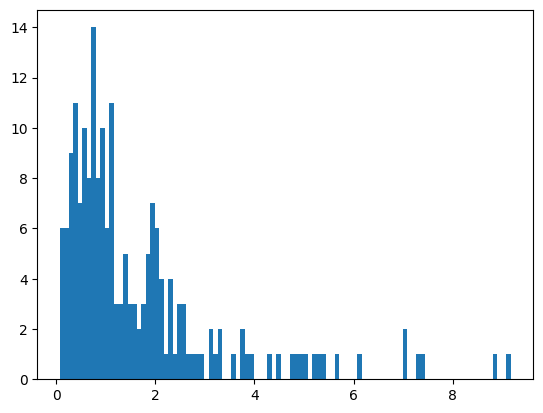

In [ ]:
plt.figure()
plt.hist(d2d.arcsec[d2d<10*u.arcsec],bins=100)
plt.show()

In [ ]:
#QUERY million quasar catalog


mlq_table=Heasarc.query_region(par_coords_list[i],catalog='milliquas',radius=check_radius)

print(mlq_table.colnames)

mlq_cols='ra,dec,broad_type,redshift, rmag, bmag,name, radio_name, xray_name'

for i in range(len(par_coords_list)):
    
    #the first one
    if i==0:
        mlq_table=Heasarc.query_region(par_coords_list[i],catalog='milliquas',radius=check_radius,columns=mlq_cols)
        add_col=tab.Column(np.repeat(par_names[i],len(mlq_table)),name='par_name')
        mlq_table.add_column(add_col)
        continue
    current_par=par_names[i]
    add_table=Heasarc.query_region(par_coords_list[i],catalog='milliquas',radius=check_radius,columns=mlq_cols)
    add_col=tab.Column(np.repeat(par_names[i],len(add_table)),name='par_name')
    add_table.add_column(add_col)
    mlq_table=tab.vstack([mlq_table,add_table])

print(mlq_table)

#do a cross match between par objects and milliquas


['name', 'ra', 'dec', 'broad_type', 'rmag', 'bmag', 'redshift', 'radio_name', 'xray_name', '__row']


    ra      dec    broad_type ...       xray_name       par_name
   deg      deg               ...                               
--------- -------- ---------- ... --------------------- --------
170.06190  6.56145        ARX ... 4XMM J112014.8+063341   Par001
169.99787  6.61146        QRX ... CXOX J111959.5+063640   Par001
177.15566 52.73784          Q ...                         Par002
150.40667  2.36542         QX ... CXOG J100137.5+022155   Par003
150.44442  2.36975         KX ... CXOG J100146.6+022210   Par003
150.42191  2.38548         QX ... CXOG J100141.2+022307   Par003
150.45846  2.39733         QX ... CXOG J100150.0+022349   Par003
150.36614  2.39946         KX ... CXOG J100127.9+022358   Par003
150.43815  2.41579         QX ... CXOG J100145.1+022456   Par003
      ...      ...        ... ...                   ...      ...
169.98174  6.78501          X ... CXOG J111955.6+064706   Par059
157.57904  5.48257         QX ... 4XMM J103018.9+052856   Par060
157.61079  5.52294       